#  Preparing estimates of daily Covid cases in Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum


### Converting data from WEEKLY positive test results to DAILY cases
This script converts the weekly data showing the number of new positive test results in the last 7 day period into an estimate of the number of new cases each day.  

This conversion process includes the following steps:
* Linearly interpolating from weekly to daily data 
    * <i> The finest resolution data provided by the Government at MSOA level is sums of new positive test results over seven day periods. To estimate the underlying daily values from this data a linear interpolation is carried out which distributes the total number of cases over a seven day window evenly over those seven days.  </i>
* Shifting the data back in time by 6 days
    * <i> This takes into account evidence suggesting that Covid has a incubation period (i.e. the time between infection and onset of symptoms) of 5-6 days. Assuming that most test are taken due to presence of symptoms, positive test result data can be converted into infection data by shifting them back in time by 5-6 days) </i>
* Multiplying the data by a month-specific multiplier 
    * <i> This takes into account evidence that tests do not pick up all infections, and therefore test data does not adequately represent the true number of infections in the population. An improved estimate of the number of infections in the population can be acquired through applying a multiplier to the positive cases data. Multipliers are applied to the data here based upon outputs of research by Phipps et al (2020), who applied a backcasting approach to estimate the true distribution of Covid in the population, and derived multipliers through comparison of this to the positive case data  </i>
* Smoothing the data  
    * <i> This linear interpolation process leads to data with unnatural steps in it, and so the data is smoothed to try to approximate a more realistic trend in infections.   </i>

Daily estimates of cases are calcaulated for both Devon as a whole and for each MSOA seperately.

Phipps, S.J., Grafton, R.Q. and Kompas, T., 2020. Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach. Royal Society open science, 7(11), p.200909.


In [1]:
## Set up python environment
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np  
import matplotlib.cm as cm
from csaps import csaps
from itertools import repeat

# Define functions
################################################################
# Function which converts weekly values into daily values
# This takes the weekly total and divides by 7 and assigns each of
# the previous 7 days with this value
################################################################
def interpolate_weekly_to_daily (weekly_df, colname, smooth_factor):
    # Create dataframe with column containing all dates for range between which data is found across any MSOA
    dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-13', end = '2021-05-07', freq='D')})
    # Create list to store the new daily cases values
    # Populate it with one value. This corresponds to the first week for which there is data. Divide this by 7
    # and include it once, as other days it refers to are not included. 
    new_cases_ls =[(weekly_df[colname][0])/7]
    # Loop through each week, find 1/7th of the weekly values and add it to the list of values 7 times
    # these will be assigned to each day in the week (ending on the week date)
    for i in range(1, len(weekly_df)):
        cases_this_week = weekly_df[colname][i]
        date = weekly_df['Date'][i]
        cases_each_day_this_week = cases_this_week/7
        new_cases_ls.extend(repeat(cases_each_day_this_week, 7))
    # Create dataframe
    daily_df =pd.DataFrame({'Date':dates['Date'],
                       'ShiftedInfections':new_cases_ls})
    # Smooth data
    daily_df =smooth_with_cubic_splines(daily_df.copy(), smooth_factor)
    return daily_df

################################################################
# Function which shifts cases back in time 6 days
# This involves losing the first data values, and the last  dates
################################################################
# def shift_cases(df, ndays):
#     # Shift the cases back by 6 days
#     df_corrected = pd.DataFrame({'Date':df['Date'].iloc[:-6].reset_index(drop=True),
#                             'OriginalCases': df['Cases'].iloc[:-6].reset_index(drop=True),
#                             'ShiftedCases':df['Cases'].iloc[6:].reset_index(drop = True)})
#     return (df_corrected)

def shift_cases(df, n_days):
    # Shift back the date of the week by 6 days
    df['Date'] =  df['Date'] -  timedelta(days=n_days)
    # rename column
    df = df.rename(columns={df.columns[1]: 'ShiftedCases'})
    return df

################################################################
# Function which applies multipliers based on the month
################################################################
# Define multipliers (roughly taken from paper)
multipliers_dict = {'Mar2020':(100/3), 'Apr2020':(100/4),'May2020': (100/5), 'Jun2020':(100/6), 'Jul2020':(100/7), 
                    'Aug2020':(100/8),'Sep2020':(100/9),'Oct2020':(100/9),
                    'Nov2020':(100/9),'Dec2020':(100/9),'Jan2021':(100/9),'Feb2021':(100/9),
                    'Mar2021':(100/9), 'Apr2021':(100/9),'May2021':(100/9)}

def apply_multipliers(df):
    # Loop through rows in cases dataframe and check the month and year and then apply the correct multiplier
    # Save the results into a list
    df_multiplied = df.copy()
    infections= []
    for row in df.itertuples():
        month = row.Date.strftime("%b")
        year = row.Date.strftime("%Y")
        multiplier = multipliers_dict[month+year]
        infections.append(row.ShiftedCases * multiplier)

    # Add column to dataframe using the list
    df_multiplied['ShiftedInfections'] = infections
    
    return df_multiplied

################################################################
# Function which smooths data using CSAPS package
################################################################
def smooth_with_cubic_splines(df, smooth_factor):
    df = df.copy()
    case_data = df['ShiftedInfections'].values
    case_data_locations = np.array(list(range(0, len(case_data))))
    xi = np.linspace(case_data_locations[0], case_data_locations[-1], len(case_data))
    df['SmoothedShiftedInfections'] = csaps(case_data_locations, case_data, xi, smooth=smooth_factor)
    df['SmoothedShiftedInfections'].values[df['SmoothedShiftedInfections'] < 0] = 0
    return df

## Download COVID test data for the UK from government website

In [2]:
# Define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
# Download data
df = pd.read_csv(new_url)

## Keep only data for MSOAs in Devon, and reformat
Use msoa_codes of msoas in devon to filter the data

In [3]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

# Convert to datetime
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'])

# Sort by date (again!)
weekly_cases_msoas.sort_values(by='Date', inplace =True)
weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004151,2020-03-19,3
E02004204,2020-03-26,3
E02004140,2020-03-26,3
E02004193,2020-03-26,5
E02004233,2020-04-02,4


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [4]:
# Create dataframe containing all dates that exist in this timeframe (to take account for fact some weeks 
# have no cases in ANY of the msoas)
dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-19', end = '2021-05-13', freq='W-Thu')})

# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)
# reindex
weekly_cases_msoas = weekly_cases_msoas.reset_index(drop = True)
weekly_cases_msoas.head()

,Date,E02004151,E02004204,E02004140,E02004193,E02004233,E02004138,E02004196,E02004160,E02004202,...,E02004220,E02004212,E02004228,E02004135,E02004217,E02004185,E02004188,E02004181,E02004232,E02004225
0,2020-03-19,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-26,NaN,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-02,3.0,NaN,NaN,4.0,4.0,3.0,3.0,6.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-09,3.0,NaN,7.0,NaN,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-16,4.0,NaN,NaN,3.0,5.0,5.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0
This is where individual MSOAs didn't have data for some of the dates in the period

In [5]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)

#### Plot data - For each of the MSOAs individually (for a sample of the MSOAs)

In [6]:
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     one_msoa = weekly_cases_msoas[['Date', msoa_code]]
       
#     ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
#     #ax.set_xlabel("Date", fontsize= 16)
#     #ax.set_xlabel("Date", fontsize= 16)
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
#     ax.legend()
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

## Interpolate from weekly to daily data

In [26]:
# Define how much to smooth the data after interpolating
# The CLOSER to 1 the LESS the data is smoothed
smooth_factor1 =0.9

# Get list of MSOA codes
msoa_codes = weekly_cases_msoas.columns[1:]

################################################################
# Loop through each MSOA, extract the data for that MSOA and 
# use the function (defined at top of script) to interpolate from weekly to daily data
# Save each MSOA df to list, and at end join together into one dataframe
################################################################
# Create lists to store each MSOA dataframe from loop
interpolated_dfs = []
# Loop
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = weekly_cases_msoas[['Date', msoa_code]].copy()
    # Interpolate cases from weekly to 0
    one_msoa_interpolated = interpolate_weekly_to_daily(one_msoa, msoa_code, smooth_factor1)
    # rename column for interpolated cases
    one_msoa_interpolated = one_msoa_interpolated.rename(columns={"SmoothedShiftedInfections":msoa_code})
    # Add to interpolated dataframe list (if first MSOA then also add the dates)
    if msoa_code == msoa_codes[0]:
        interpolated_dfs.append(one_msoa_interpolated[['Date',msoa_code]]) 
    else:
        interpolated_dfs.append(one_msoa_interpolated[[msoa_code]])           

# Join list of interpolated dataframes into one      
daily_cases_msoas = pd.concat(interpolated_dfs, axis=1)
daily_cases_msoas.head()

################################################################
# Plot for some MSOAs
################################################################
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     one_msoa = daily_cases_msoas[['Date', msoa_code]]
#     ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
#     ax.legend()
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

,Date,E02004151,E02004204,E02004140,E02004193,E02004233,E02004138,E02004196,E02004160,E02004202,...,E02004220,E02004212,E02004228,E02004135,E02004217,E02004185,E02004188,E02004181,E02004232,E02004225
0,2020-03-13,0.391122,0.037449,0.037449,0.062385,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.225826e-113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.828213e-120,4.874759e-120,3.832261e-124,2.736035e-124
1,2020-03-14,0.067321,0.361250,0.361250,0.602061,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.392309e-112,1.691998e-116,2.818694e-116,2.818694e-116,2.819995e-116,3.383994e-116,0.000000e+00,0.000000e+00,4.349381e-123,3.106583e-123
2,2020-03-15,0.000000,0.448989,0.448989,0.748608,0.000293,0.000220,0.000220,0.000439,0.000220,...,0.000000e+00,1.726928e-115,2.877905e-115,2.877905e-115,2.878214e-115,3.453856e-115,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2020-03-16,0.000000,0.437903,0.437903,0.730762,0.000924,0.000693,0.000693,0.001386,0.000693,...,0.000000e+00,2.127657e-115,3.546804e-115,3.546804e-115,3.546096e-115,4.255315e-115,5.307349e-119,1.415927e-118,0.000000e+00,0.000000e+00
4,2020-03-17,0.000000,0.429706,0.429707,0.714944,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.843876e-118,1.025154e-117,0.000000e+00,0.000000e+00


## Shifting, multiplying, smoothing interpolated daily case data
Taking the data for one MSOA at a time, shifts the case data back 6 days, applies month-specific multiplier, and finally smoothes data

In [27]:
# Define how much to smooth the data after shifting and multiplying
# The CLOSER to 1 the LESS the data is smoothed
smooth_factor2 =0.2

# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_mpld_dfs = []
shifted_mpld_smoothed_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift cases, multiply cases and save to lists (to convert 
# later back into one dataframe with just shfited data and 
# one with just multiplied data - one column per MSOA)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = daily_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_mpld = apply_multipliers(one_msoa_shifted)
    # Smooth cases
    one_msoa_shifted_mpld_smoothed = smooth_with_cubic_splines(one_msoa_shifted_mpld, smooth_factor2)
    
    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    
    # rename column for shifted, multiplied cases
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_mpld = one_msoa_shifted_mpld.drop(['ShiftedCases'], axis=1)
    
    # rename column for shifted, multiplied, smoothed cases
    one_msoa_shifted_mpld_smoothed = one_msoa_shifted_mpld_smoothed.rename(columns={"SmoothedShiftedInfections":msoa_code})
    
    # Add to shifted dataframe list
    if not shifted_dfs:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])

    # Add to multiplied dataframe list
    if not shifted_mpld_dfs:
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[['Date',msoa_code]])
    else:
        shifted_mpld_dfs.append(one_msoa_shifted_mpld[[msoa_code]])   

    # Add to smoothed dataframe list
    if not shifted_mpld_smoothed_dfs:
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[['Date',msoa_code]])
    else:
        shifted_mpld_smoothed_dfs.append(one_msoa_shifted_mpld_smoothed[[msoa_code]])      
        
# Join list of dataframes into one - shifted       
daily_cases_msoas_shifted = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
daily_cases_msoas_shifted_mpld = pd.concat(shifted_mpld_dfs, axis=1)
# Join list of dataframes into one - multiplied        
daily_cases_msoas_shifted_mpld_smoothed = pd.concat(shifted_mpld_smoothed_dfs, axis=1)
daily_cases_msoas_shifted_mpld_smoothed.head()

,Date,E02004151,E02004204,E02004140,E02004193,E02004233,E02004138,E02004196,E02004160,E02004202,...,E02004220,E02004212,E02004228,E02004135,E02004217,E02004185,E02004188,E02004181,E02004232,E02004225
0,2020-03-07,8.924077,5.430968,5.429310,8.973083,0.0,0.0,0.0,0.0,0.0,...,5.424534e-46,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.209448e-49,1.991545e-48,0.000000e+00,0.000000e+00
1,2020-03-08,4.906461,9.560385,9.576979,15.570126,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.479090e-49,7.122583e-49,0.000000e+00,0.000000e+00
2,2020-03-09,1.806241,12.747526,12.782093,20.631215,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,2.610123e-47,4.309123e-47,4.310027e-47,4.350395e-47,5.220435e-47,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2020-03-10,0.021818,14.556111,14.603891,23.550257,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,6.363602e-47,1.041251e-46,1.040758e-46,1.059740e-46,1.271827e-46,0.000000e+00,0.000000e+00,6.802448e-50,4.849518e-50
4,2020-03-11,0.000000,15.024741,15.068047,24.662688,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,1.093687e-46,1.779630e-46,1.778027e-46,1.820369e-46,2.184839e-46,0.000000e+00,0.000000e+00,1.922944e-49,1.355638e-49


## Plot the number of cases over time for one MSOA, including:
 * original weekly case data
 * daily case data
 * time shifted and multiplied daily case data  
 * time shifted, multiplied and smoothed daily case 

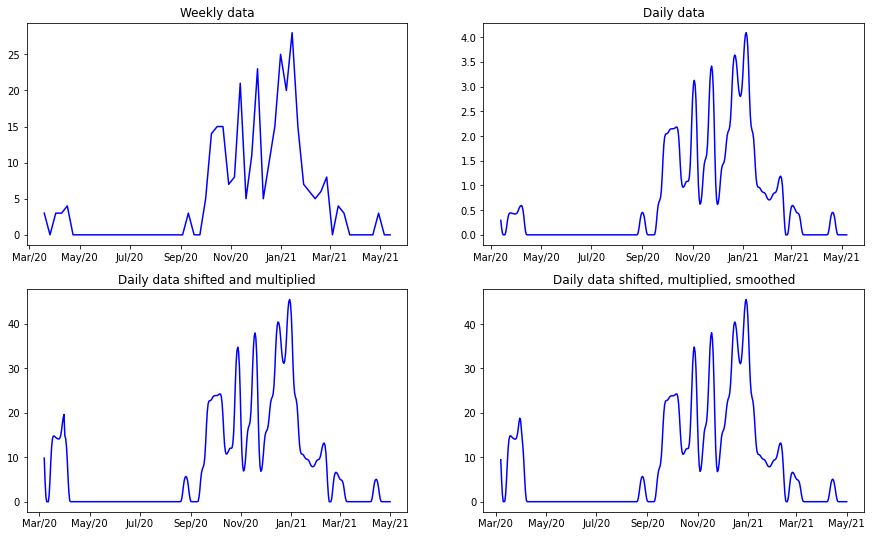

In [24]:
# Choose MSOA
msoa_code = msoa_codes[0]

fig, ax = plt.subplots(figsize =(15,9), sharey= False)
ax.axis('off')
ax1 = fig.add_subplot(221)
ax1.plot(weekly_cases_msoas['Date'], weekly_cases_msoas[msoa_code], label="Original cases", color="blue")
ax1.title.set_text('Weekly data')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax2 = fig.add_subplot(222)
ax2.plot(daily_cases_msoas['Date'], daily_cases_msoas[msoa_code], label="Original cases", color="blue")
ax2.title.set_text('Daily data')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax3 = fig.add_subplot(223)
ax3.plot(daily_cases_msoas_shifted_mpld['Date'], daily_cases_msoas_shifted_mpld[msoa_code], label="Original cases", color="blue")
ax3.title.set_text('Daily data shifted and multiplied')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))

ax4 = fig.add_subplot(224)
ax4.plot(daily_cases_msoas_shifted_mpld_smoothed['Date'], daily_cases_msoas_shifted_mpld_smoothed[msoa_code], label="Original cases", color="blue")
ax4.title.set_text('Daily data shifted, multiplied, smoothed')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
plt.show()


## Join data for whole of Devon

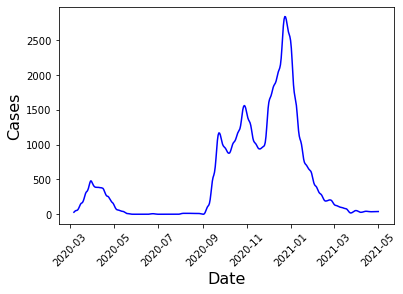

In [28]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each week
    totals_df['OriginalCases']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df

daily_cases_devon_shifted_mpld_smoothed = find_devon_totals(daily_cases_msoas_shifted_mpld_smoothed) 
weekly_cases_devon = find_devon_totals(weekly_cases_msoas)

##################################################################################
# Plot
##################################################################################
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(daily_cases_devon_shifted_mpld_smoothed['Date'], daily_cases_devon_shifted_mpld_smoothed['OriginalCases'], label="Shifted cases", color="blue")

## Save to csv files

In [11]:
daily_cases_devon_shifted_mpld_smoothed.to_csv("daily_cases_devon_shifted_mpld_smoothed_IF.csv", index=False)
daily_cases_msoas_shifted_mpld_smoothed.to_csv("daily_cases_msoas_shifted_mpld_smoothed_IF.csv", index=False)

## Compare weekly and daily data
We also need weekly data for the model (for use in the distance function).  
We can't compare this to anything in this case, as we don't multiply, shift, smooth the weekly data before interpolation

In [13]:
# Get weekly values from daily
weekly_cases_devon_aggregated_from_daily = daily_cases_devon_shifted_mpld_smoothed.resample('W-Fri', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
weekly_cases_msoas_aggregated_from_daily = daily_cases_msoas_shifted_mpld_smoothed.resample('W-Tue', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')

# Save
weekly_cases_devon_aggregated_from_daily.to_csv("weekly_cases_devon_aggregated_from_daily_IF.csv", index=False)
weekly_cases_msoas_aggregated_from_daily.to_csv("weekly_cases_msoas_aggregated_from_daily_IF.csv", index=False)

## Compare with method used in CreatingObservations-Daily-InterpolateSecond.ipynb

### Devon totals - daily

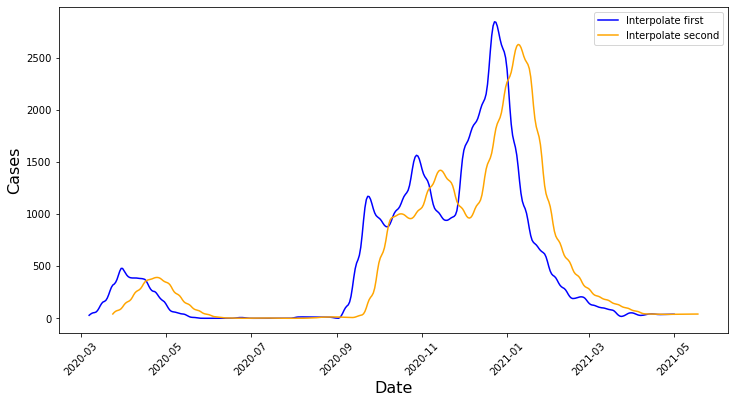

In [14]:
# Read in daily data for Devon for both methods
daily_cases_devon_shifted_mpld_smoothed_IS =  pd.read_csv("daily_cases_devon_shifted_mpld_smoothed_IS.csv")
daily_cases_devon_shifted_mpld_smoothed_IF= pd.read_csv("daily_cases_devon_shifted_mpld_smoothed_IF.csv")
# Reformat dates
daily_cases_devon_shifted_mpld_smoothed_IF['Date'] =  pd.to_datetime(daily_cases_devon_shifted_mpld_smoothed_IF['Date'])
daily_cases_devon_shifted_mpld_smoothed_IS['Date'] =  pd.to_datetime(daily_cases_devon_shifted_mpld_smoothed_IS['Date'])

##################################################################################
# Plot to compare
##################################################################################
# shared axis
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(daily_cases_devon_shifted_mpld_smoothed_IF['Date'], daily_cases_devon_shifted_mpld_smoothed_IF['OriginalCases'], label="Interpolate first", color="blue")
plt.plot(daily_cases_devon_shifted_mpld_smoothed_IS['Date'], daily_cases_devon_shifted_mpld_smoothed_IS['OriginalCases'], label="Interpolate second", color="orange")
plt.legend()
plt.show()

### MSOA totals - daily

In [ ]:
daily_cases_msoas_shifted_mpld_smoothed_IS =  pd.read_csv("daily_cases_msoas_shifted_mpld_smoothed_IS.csv")
daily_cases_msoas_shifted_mpld_smoothed_IF = pd.read_csv("daily_cases_msoas_shifted_mpld_smoothed_IF.csv")
# change date format
daily_cases_msoas_shifted_mpld_smoothed_IF['Date'] =  pd.to_datetime(daily_cases_msoas_shifted_mpld_smoothed_IF['Date'])
daily_cases_msoas_shifted_mpld_smoothed_IS['Date'] =  pd.to_datetime(daily_cases_msoas_shifted_mpld_smoothed_IS['Date'])

msoa_code = msoa_codes[0]
one_msoa_IF = daily_cases_msoas_shifted_mpld_smoothed_IF[['Date', msoa_code]]
one_msoa_IS = daily_cases_msoas_shifted_mpld_smoothed_IS[['Date', msoa_code]]

##################################################################################
# Plot
#################################################################################
# shared axis
fig, ax = plt.subplots(figsize =(12,6))
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(one_msoa_IF['Date'], one_msoa_IF[msoa_code], label="Interpolate first", color="blue")
plt.plot(one_msoa_IS['Date'], one_msoa_IS[msoa_code], label="Interpolate second", color="orange")
plt.legend()
plt.show()

### Devon totals - weekly

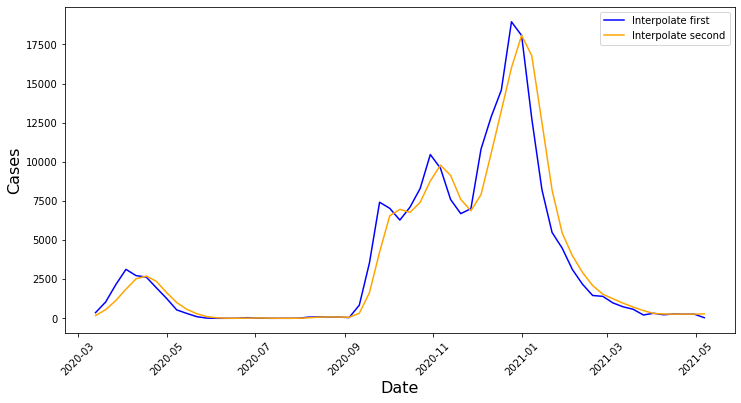

,Date,OriginalCases
0,2020-03-13,359.093223
1,2020-03-20,1041.136173
2,2020-03-27,2148.726106
3,2020-04-03,3125.150618
4,2020-04-10,2725.626994
...,...,...
56,2021-04-09,226.985016
57,2021-04-16,277.958731
58,2021-04-23,260.469933
59,2021-04-30,267.705364


In [18]:
weekly_cases_devon_aggregated_from_daily_IS = pd.read_csv("weekly_cases_devon_aggregated_from_daily_IS.csv")
weekly_cases_devon_aggregated_from_daily_IF = pd.read_csv("weekly_cases_devon_aggregated_from_daily_IF.csv")
# change date format
weekly_cases_devon_aggregated_from_daily_IF['Date'] =  pd.to_datetime(weekly_cases_devon_aggregated_from_daily_IF['Date'])
weekly_cases_devon_aggregated_from_daily_IS['Date'] =  pd.to_datetime(weekly_cases_devon_aggregated_from_daily_IS['Date'])

##################################################################################
# Plot to compare
##################################################################################
# shared axis
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(weekly_cases_devon_aggregated_from_daily_IF['Date'], weekly_cases_devon_aggregated_from_daily_IF['OriginalCases'], label="Interpolate first", color="blue")
plt.plot(weekly_cases_devon_aggregated_from_daily_IS['Date'], weekly_cases_devon_aggregated_from_daily_IS['OriginalCases'], label="Interpolate second", color="orange")
plt.legend()
plt.show()